## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

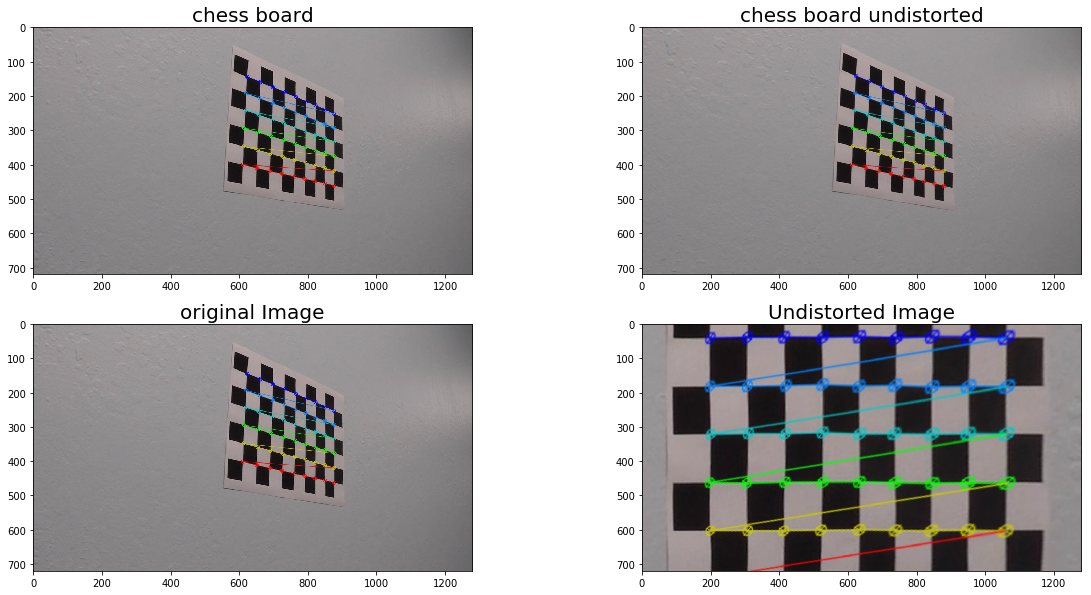

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os

#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
rets = []
mtxs = []
dists = []
rvecss = []
tvecss = []

def corners_unwarp(img, nx, ny, mtx, dist):
    # Undistort using mtx and dist
    img = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        # a) draw corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
        src = np.float32([corners[0],corners[7],corners[40],corners[47]])
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[200,160],[1050,160],[200,740],[1050,740]])
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
        return warped, M

# Make a list of calibration images
images = glob.glob('..\camera_cal\calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('chess board', fontsize=20)

        
#Camera calibration, given object points, image points, and the shape of the grayscale image:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
#Undistorting a test image:
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imshow('undistorted ',undistorted )
cv2.waitKey()
 
ax2.imshow(undistorted)
ax2.set_title('chess board undistorted', fontsize=20)

# define 4 source points src = np.float32([[,],[,],[,],[,]])
src = np.float32([corners[0],corners[8],corners[45],corners[53]])
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
dst = np.float32([[200,50],[1050,50],[200,740],[1050,740]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
            # e) use cv2.warpPerspective() to warp your image to a top-down view
topdown = cv2.warpPerspective(undistorted, M, (undistorted.shape[1],undistorted.shape[0]), flags=cv2.INTER_LINEAR)
                          
ax3.imshow(img)
ax3.set_title('original Image', fontsize=20)  
ax4.imshow(topdown)
ax4.set_title('Undistorted Image', fontsize=20)
    
cv2.imshow('warped',topdown)
cv2.waitKey()

cv2.destroyAllWindows()

In [1]:
## save the calibration in case

In [3]:
import pickle
def save_calibration(mtx, dist, folder='..\\camera_cal'):
    # Save the camera calibration result for later use
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( folder+"/calibration_pickle.p", "wb" ) )

## Next, load the road images and correct for the lens

In [ ]:
import math

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    right_line_bottom = []
    right_line_top = []
    left_line_bottom = []
    left_line_top = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #original code
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)       
            
            #create a single line from the average line formulas of the existing lines
            #find the x values for the top and bottom of the assessed region
            #for each line segment, and average the right and left line segments to find
            #a single best left and single best right line.
            m = ((y2-y1)/(x2-x1))
            b = (y2-(m*x2)) #b=y-mx 
            xbottom = ((img.shape[1]-b)/m)#y=mx+b where y=0
            xtop = ((int(imshape[0]/2)+50-b)/m)#y=mx+b where y=325, top of region considered
            
            print(m)

            if m > 1:
                left_line_bottom.append(xbottom)
                left_line_top.append(xtop)
            else:
                if m<-1:
                    right_line_bottom.append(xbottom)
                    right_line_top.append(xtop)
    
    #average the right line's bottom points, average the top points, draw a line between them
    rlba = np.mean(right_line_bottom, dtype=np.float64) #right line bottom average
    if rlba == float("inf") or rlba == float("-inf"):
        if right_line_bottom[0] == float("inf") or right_line_bottom[0] == float("-inf"):
            rlba = right_line_bottom[2]            
        else: 
            rlba = right_line_bottom[0]
        
    rlta = np.mean(right_line_top, dtype=np.float64)    #right line top average
    if rlta == float("inf") or rlta == float("-inf"):
        if right_line_top[0] == float("inf") or right_line_top[0] == float("-inf"):
            rlta = right_line_top[2]            
        else:
            rlta = right_line_top[0]

    cv2.line(img, (int(rlta), 325), (int(rlba), img.shape[1]), color, thickness) #draw right line between average top and bottom
    
    #average the left line's bottom points, average the top points, draw a line between them
    llba = np.mean(left_line_bottom) #left line bottom average
    if llba == float("inf") or llba == float("-inf"):
        if left_line_bottom[0] == float("inf") or left_line_bottom[0] == float("-inf"):
            llba = left_line_bottom[2]            
        else:  
            llba = left_line_bottom[0]

        llba = right_line_bottom[0]
    llta = np.mean(left_line_top)    #left line top average
    if llta == float("inf") or llta == float("-inf"):
        if left_line_top[0] == float("inf") or left_line_top[0] == float("-inf"):
            llta = left_line_top[2]            
        else:
            llta = left_line_top[0]
          
    cv2.line(img, (int(llta), int(imshape[0]/2)+50), (int(llba), img.shape[1]), color, thickness) #draw leftt line between average top and bottom             
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):

    return cv2.addWeighted(initial_img, α, img, β, λ)

In [ ]:
def processimage(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    #img = np.copy(img)
    print(img.shape)
    r = img[:,:,0]
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold l channel
    r_binary = np.zeros_like(r)
    r_binary[(r >= 220) & (r <= 255)] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(24, 13))
    f.tight_layout()
    f.suptitle("Sobel X with R channel & S channel thresholded :", fontsize=30)

    ax1.imshow(img)
    ax1.set_title('Original image', fontsize=20)

    ax4.imshow(r_binary)
    ax4.set_title('R binary', fontsize=20)

    ax2.imshow(s_binary)
    ax2.set_title('S channel binary', fontsize=20)

    ax5.imshow(s_channel)
    ax5.set_title('S channel of image HSV', fontsize=20)

    ax3.imshow(sxbinary, cmap='gray')
    ax3.set_title('Binary Sobel X', fontsize=20)
            
    final_binary[r_binary==1 | sxbinary==1 | s_binary ==1] =1

    ax6.imshow(final_binary, cmap='gray')
    ax6.set_title('Final Binary', fontsize=20)
                 
    return final_binary#color_binary

In [ ]:
#TESTING

tstimage = cv2.imread('..\\test_images\\straight_lines1.jpg')
#tstimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

result = processimage(image)


In [ ]:
#pipeline to read in images and save out the final result (pipeline test!!!!!!!)
for imagename in os.listdir("..\\test_images\\"):
    imagein=mpimg.imread("..\\test_images\\"+imagename) #read in the image

#for i in range(1):
    #imagein = mpimg.imread('..\\test_images\straight_lines1.jpg')    
    image = processimage(imagein, (170, 255), sx_thresh=(20, 100))
    print(imagein.shape)
    gray = np.copy(image) #copy original image to instance "gray"
    
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #convert to greyscale
    #print(gray.shape)
    #cv2.imwrite("output_images/problemImagegray.jpg",gray) #output the image to local file

    #gray = gaussian_blur(gray, 9) #blur out some of the noise
    #gray = canny(gray, 20, 70) #Canny edge detection to simplify finding edges
    
    #cv2.imwrite("output_images/problemImagecanny.jpg",gray) #output the image to local file
    
    imshape = image.shape #get image shape
    #print(imshape)
    x1 = int(imshape[1]/2)-53
    x2 = int(imshape[1]/2)+53
    y1 = int(imshape[0]/2)+90
    y2 = int(imshape[0]-50)

    #vertices = np.array([[(x1, y1), (x2,y1), (imshape[1]-90,y2), (90,y2)]], dtype=np.int32) #build vert list per 15: quiz
    #gray = region_of_interest(gray, vertices) #define region of interest to apply lines to 
    
    #cv2.imwrite("../output_images/problemImageRegion.jpg",gray) #output the image to local file
    
    #line_image = np.copy(image)*0 #make a copy of image to work against
    #line_image = hough_lines(gray, 1, np.pi/180, 30, 40, 100)
    
    #weighted_image = weighted_img(line_image, image, α=0.8, β=1., λ=0.)
    #plt.imshow(weighted_image) #show final image to make sure we've made it this far
    
    #cv2.imwrite("../output_images/problemImageLines.jpg",line_image) #output the image to local file
 
    #Undistorting image:
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    cv2.imshow('undistorted ',undistorted )
    cv2.waitKey()
    #cv2.imwrite("../output_images/problemImageUndistortedImage.jpg",undistorted) #output the images to local files
 
    # define 4 source points src = np.float32([[,],[,],[,],[,]])
    src = np.float32([[(x1, y1), (x2,y1), (imshape[1]-200,y2),(200,y2)]])
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[200,50],[1080,50],[1080,670],[200,670]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    topdown = cv2.warpPerspective(undistorted, M, (undistorted.shape[1],undistorted.shape[0]), flags=cv2.INTER_LINEAR)
                                             
    cv2.imshow('warped',topdown)
    cv2.waitKey()
    #cv2.imwrite("../output_images/Topdown"+imagename,topdown) #output the images to local files
    
    #Find the lines
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(topdown[topdown.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((topdown, topdown, topdown))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(topdown.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = topdown.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = topdown.shape[0] - (window+1)*window_height
        win_y_high = topdown.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, topdown.shape[0]-1, topdown.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    #weighted_image = weighted_img(line_image, image, α=0.8, β=1., λ=0.)
    #plt.imshow(weighted_image) #show final image to make sure we've made it this far
    
    #cv2.imwrite("../output_images/problemImageWeightedImage.jpg",weighted_image) #output the images to local files

    cv2.destroyAllWindows()

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    cv2.imwrite("challengemovieout/problemImage.jpg",image) #output the image to local file
    #image2=mpimg.imread("challengemovieout/problemImage.jpg",image)
    #cv2.imwrite("challengemovieout/problemImage.jpg",image2) #output the image to local file

    #image = image2
    gray = np.copy(image) #copy original image to instance "gray"
    cv2.imwrite("challengemovieout/problemImage2.jpg",gray) #output the image to local file

    gray = grayscale(gray) #convert to greyscale
    
    cv2.imwrite("challengemovieout/problemImagegray.jpg",gray) #output the image to local file
    
    gray = gaussian_blur(gray, 9) #blur out some of the noise
    gray = canny(gray, 20, 80) #Canny edge detection to simplify finding edges
    
    cv2.imwrite("challengemovieout/problemImagecanny.jpg",gray) #output the image to local file
    
    imshape = image.shape #get image shape
    
    x1 = int(imshape[1]/2)-30
    x2 = int(imshape[1]/2)+30
    y1 = int(imshape[0]/2)+50
    
    vertices = np.array([[(0,imshape[0]),(x1, y1), (x2,y1), (imshape[1],imshape[0])]], dtype=np.int32) #build vert list per 15: quiz
    gray = region_of_interest(gray, vertices) #define region of interest to apply lines to 

    cv2.imwrite("challengemovieout/problemImageRegion.jpg",gray) #output the image to local file
    
    line_image = np.copy(image)*0 #make a copy of image to work against
    line_image = hough_lines(gray, 2, np.pi/180, 50, 40, 200)
    
    
     
    result = weighted_img(line_image, image, α=0.8, β=1., λ=0.)

    return result

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))